In [1]:
import pandas as pd
!pip install dataretrieval
from dataretrieval import nwis
import numpy as np
import os
os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import math
from datetime import datetime
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)

Current time: 2025-08-15 22:30:32.109413


In [2]:


startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
         "13340600" #    "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

In [3]:
site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]
#print(filtered_df)

parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

site_info_df:   agency_cd   site_no                                       station_nm  \
0      USGS  13340600  NF CLEARWATER RIVER NR CANYON RANGER STATION ID   

  site_tp_cd  lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd  \
0         ST  465026  1153716   46.840556  -115.621111             G   

  coord_acy_cd  ... reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  \
0            S  ...              C   NNNNNNNN          NaN      NaN   

   aqfr_type_cd well_depth_va hole_depth_va depth_src_cd  project_no  \
0           NaN           NaN           NaN          NaN         NaN   

                      geometry  
0  POINT (-115.62111 46.84056)  

[1 rows x 43 columns]
station_nm: NF CLEARWATER RIVER NR CANYON RANGER STATION ID


In [4]:
shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

             date      tmean   site_no  Days_Since_October_1st     rad_d
0      1995-01-01 -18.306002  06038800                      92  1.583707
1      1995-01-02 -17.829000  06038800                      93  1.600921
2      1995-01-03 -18.317001  06038800                      94  1.618135
3      1995-01-04 -15.904000  06038800                      95  1.635350
4      1995-01-05 -11.903001  06038800                      96  1.652564
...           ...        ...       ...                     ...       ...
282875 2024-10-10  14.149199  13342500                       9  0.154928
282876 2024-10-11  13.611249  13342500                      10  0.172142
282877 2024-10-12  16.385151  13342500                      11  0.189356
282878 2024-10-13  14.676150  13342500                      12  0.206570
282879 2024-10-14  16.204950  13342500                      13  0.223785

[282880 rows x 5 columns]


In [5]:
prism_df = prism_df[['tmean' , "site_no", 'Date', "rad_d" ]]
dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean',
       'Month', 'Year' ]]
result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

In [6]:
# Count the number of NaN values in each column
na_count = result.isna().sum()

# Print the result
#print(na_count)

# Drop rows with any NaN values
df_cleaned = result.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

           tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
1461    8.150001  13340600  1999-10-01  0.000000         7.9       790.0   
1462    6.753000  13340600  1999-10-02  0.017214         7.7       773.0   
1463    8.743000  13340600  1999-10-03  0.034428         7.0       767.0   
1464   12.305000  13340600  1999-10-04  0.051643         6.6       764.0   
1465   12.755001  13340600  1999-10-05  0.068857         6.8       760.0   
...          ...       ...         ...       ...         ...         ...   
10588  12.699950  13340600  2024-09-26  6.197114        14.3       702.0   
10589  14.748300  13340600  2024-09-27  6.214328        13.9       725.0   
10590  18.646999  13340600  2024-09-28  6.231543        13.9       670.0   
10591   8.926950  13340600  2024-09-29  6.248757        13.6       648.0   
10592   7.700500  13340600  2024-09-30  6.265971        11.8       629.0   

       Month  Year  
1461      10  1999  
1462      10  1999  
1463      10  1999  
146

In [7]:
def get_water_year(date):
        if date.month >= 10:
            #print(date)
            return date.year +1
            #print(date.year+1)
        else:
            return date.year



df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)

print(df_cleaned)

print(df_cleaned['water_year'].unique())

           tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
1461    8.150001  13340600  1999-10-01  0.000000         7.9       790.0   
1462    6.753000  13340600  1999-10-02  0.017214         7.7       773.0   
1463    8.743000  13340600  1999-10-03  0.034428         7.0       767.0   
1464   12.305000  13340600  1999-10-04  0.051643         6.6       764.0   
1465   12.755001  13340600  1999-10-05  0.068857         6.8       760.0   
...          ...       ...         ...       ...         ...         ...   
10588  12.699950  13340600  2024-09-26  6.197114        14.3       702.0   
10589  14.748300  13340600  2024-09-27  6.214328        13.9       725.0   
10590  18.646999  13340600  2024-09-28  6.231543        13.9       670.0   
10591   8.926950  13340600  2024-09-29  6.248757        13.6       648.0   
10592   7.700500  13340600  2024-09-30  6.265971        11.8       629.0   

       Month  Year  water_year  
1461      10  1999        2000  
1462      10  1999   

/tmp/ipython-input-1530779919.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['water_year'] = df_cleaned['Date'].apply(get_water_year)


In [8]:
amp_df = pd.DataFrame({
                        "site": [ "00000000"],
      "water_year": [  0 ],
                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })

In [9]:
df_cleaned['sin_rday'] = np.sin( df_cleaned['rad_d'] )
df_cleaned['cos_rday'] = np.cos( df_cleaned['rad_d'] )

# Group by both site_no and water_year
grouped = df_cleaned.groupby(['site_no', 'water_year'])
print(grouped)

/tmp/ipython-input-2698343029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sin_rday'] = np.sin( df_cleaned['rad_d'] )
/tmp/ipython-input-2698343029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cos_rday'] = np.cos( df_cleaned['rad_d'] )


In [10]:

# Iterate through each group
for (site_no, water_year), group_df in grouped:
#    merged_df_wy=df_cleaned[df_cleaned['site_no']== site_no ]


    num_rows = group_df.shape[0]
    print("Number of rows:", num_rows)
    if num_rows < missing_data_threshold:
        print("stop")
    else:
        print(f"Processing site_no: {site_no}, water_year: {water_year}")
        print(f"DataFrame shape: {group_df.shape}")
        print(group_df)

        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  group_df ).fit()
        #print("air_model:",air_model.summary())
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
        group_df['fit_air'] = air_model.predict( group_df )

        group_df['ST']=group_df['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= group_df ).fit()
        #print("stream_model:",stream_model.summary())
        stream_model_coefficients = stream_model.params
        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
        #print("stream_amp:", stream_amp)
        group_df['fit_stream'] = stream_model.predict( group_df )
        ## phase
        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
        #print("ph_stream:", ph_stream)
        #print("ph_air:", ph_air)
        ph_l = ph_stream - ph_air
        ##
        amp_df0 = pd.DataFrame({
                                "site": [site_no]
           , "water_year": [  water_year ]
                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df=pd.concat( [amp_df,amp_df0] )

amp_df = amp_df[1:]

Number of rows: 213
stop
Number of rows: 355
Processing site_no: 13340600, water_year: 2001
DataFrame shape: (355, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
1837   9.056001  13340600  2000-10-11  0.172142        14.3       825.0   
1838   8.205000  13340600  2000-10-12  0.189356         9.7       809.0   
1839   6.924000  13340600  2000-10-13  0.206570         8.7      1020.0   
1840   6.982000  13340600  2000-10-14  0.223785         8.6      1400.0   
1841   8.871000  13340600  2000-10-15  0.240999         8.6      1160.0   
...         ...       ...         ...       ...         ...         ...   
2187  14.259001  13340600  2001-09-26  6.197114        13.7       513.0   
2188  14.571001  13340600  2001-09-27  6.214328        13.7       527.0   
2189   8.753000  13340600  2001-09-28  6.231543        13.7       526.0   
2190  12.271001  13340600  2001-09-29  6.248757        13.0       543.0   
2191  14.757001  13340600  2001-09-30  6.265971        1

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5


Number of rows: 365
Processing site_no: 13340600, water_year: 2002
DataFrame shape: (365, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
2192  16.252001  13340600  2001-10-01  0.000000        12.0       518.0   
2193  13.275001  13340600  2001-10-02  0.017214        11.5       507.0   
2194  12.149000  13340600  2001-10-03  0.034428        11.0       500.0   
2195   9.112000  13340600  2001-10-04  0.051643        10.5       495.0   
2196   9.186001  13340600  2001-10-05  0.068857         9.0       490.0   
...         ...       ...         ...       ...         ...         ...   
2552  11.430000  13340600  2002-09-26  6.197114        11.0       728.0   
2553   8.818001  13340600  2002-09-27  6.214328        11.0       727.0   
2554  11.050000  13340600  2002-09-28  6.231543        10.5       746.0   
2555   7.225000  13340600  2002-09-29  6.248757        10.0       747.0   
2556   5.583000  13340600  2002-09-30  6.265971         9.5       976.0   

     

/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
/tmp/ipython-input-1768583108.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

Number of rows: 364
Processing site_no: 13340600, water_year: 2005
DataFrame shape: (364, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
3288  12.486001  13340600  2004-10-01  0.000000        11.2      1190.0   
3289  12.828001  13340600  2004-10-02  0.017214        10.7      1150.0   
3290  13.117001  13340600  2004-10-03  0.034428        10.2      1130.0   
3291  13.544001  13340600  2004-10-04  0.051643         9.7      1100.0   
3292  13.184001  13340600  2004-10-05  0.068857         9.4      1080.0   
...         ...       ...         ...       ...         ...         ...   
3648  12.853001  13340600  2005-09-26  6.197114        10.1       685.0   
3649  11.979001  13340600  2005-09-27  6.214328        10.3       634.0   
3650  11.637000  13340600  2005-09-28  6.231543        10.0       611.0   
3651  12.256001  13340600  2005-09-29  6.248757         9.8       603.0   
3652  11.916000  13340600  2005-09-30  6.265971         9.8       868.0   

     

/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
/tmp/ipython-input-1768583108.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

Number of rows: 365
Processing site_no: 13340600, water_year: 2007
DataFrame shape: (365, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4018  12.534000  13340600  2006-10-01  0.000000        11.3       654.0   
4019  11.333000  13340600  2006-10-02  0.017214        10.6       644.0   
4020  11.260000  13340600  2006-10-03  0.034428        10.3       643.0   
4021  13.081000  13340600  2006-10-04  0.051643        10.2       644.0   
4022  12.452001  13340600  2006-10-05  0.068857        10.6       654.0   
...         ...       ...         ...       ...         ...         ...   
4378  12.020000  13340600  2007-09-26  6.197114        11.0       667.0   
4379  14.638000  13340600  2007-09-27  6.214328        11.0       637.0   
4380   9.696000  13340600  2007-09-28  6.231543        10.9       626.0   
4381   4.824000  13340600  2007-09-29  6.248757        10.2       672.0   
4382   6.702000  13340600  2007-09-30  6.265971         9.5       700.0   

     

/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
/tmp/ipython-input-1768583108.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

Number of rows: 366
Processing site_no: 13340600, water_year: 2008
DataFrame shape: (366, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4383   7.746000  13340600  2007-10-01  0.000000         9.0       749.0   
4384   7.838000  13340600  2007-10-02  0.017214         9.0      1100.0   
4385   6.871000  13340600  2007-10-03  0.034428         9.0      1230.0   
4386   6.672000  13340600  2007-10-04  0.051643         9.0      1260.0   
4387   3.846000  13340600  2007-10-05  0.068857         8.5       952.0   
...         ...       ...         ...       ...         ...         ...   
4744  13.155001  13340600  2008-09-26  6.197114        11.0       946.0   
4745  13.049001  13340600  2008-09-27  6.214328        11.5       915.0   
4746  13.432001  13340600  2008-09-28  6.231543        11.0       890.0   
4747  15.188001  13340600  2008-09-29  6.248757        11.0       874.0   
4748  17.489000  13340600  2008-09-30  6.265971        10.5       860.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 365
Processing site_no: 13340600, water_year: 2009
DataFrame shape: (365, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
4749  18.795000  13340600  2008-10-01  0.000000        11.0       847.0   
4750  16.764000  13340600  2008-10-02  0.017214        11.5       837.0   
4751  15.005001  13340600  2008-10-03  0.034428        12.0       847.0   
4752  11.472000  13340600  2008-10-04  0.051643        12.5       897.0   
4753   8.012000  13340600  2008-10-05  0.068857        12.0      1190.0   
...         ...       ...         ...       ...         ...         ...   
5109  16.215000  13340600  2009-09-26  6.197114        13.5       704.0   
5110  13.265000  13340600  2009-09-27  6.214328        13.0       692.0   
5111  15.435000  13340600  2009-09-28  6.231543        12.0       684.0   
5112   7.932000  13340600  2009-09-29  6.248757        11.5       684.0   
5113   3.463000  13340600  2009-09-30  6.265971        10.5       689.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 365
Processing site_no: 13340600, water_year: 2010
DataFrame shape: (365, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
5114   5.429000  13340600  2009-10-01  0.000000         9.5       714.0   
5115   7.057000  13340600  2009-10-02  0.017214         9.0       719.0   
5116   8.213000  13340600  2009-10-03  0.034428         9.0       748.0   
5117   7.423000  13340600  2009-10-04  0.051643         9.0       725.0   
5118   6.865000  13340600  2009-10-05  0.068857         8.5       682.0   
...         ...       ...         ...       ...         ...         ...   
5474  14.929001  13340600  2010-09-26  6.197114        13.0       790.0   
5475  18.052000  13340600  2010-09-27  6.214328        13.0       771.0   
5476  17.973001  13340600  2010-09-28  6.231543        13.5       754.0   
5477  17.907001  13340600  2010-09-29  6.248757        14.0       743.0   
5478  18.117001  13340600  2010-09-30  6.265971        14.0       734.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5


Number of rows: 365
Processing site_no: 13340600, water_year: 2011
DataFrame shape: (365, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
5479  18.545000  13340600  2010-10-01  0.000000        14.0       724.0   
5480  18.028002  13340600  2010-10-02  0.017214        13.5       712.0   
5481  16.682001  13340600  2010-10-03  0.034428        13.0       704.0   
5482  10.562000  13340600  2010-10-04  0.051643        13.0       739.0   
5483  11.489000  13340600  2010-10-05  0.068857        13.0       815.0   
...         ...       ...         ...       ...         ...         ...   
5839  13.831000  13340600  2011-09-26  6.197114        13.0       811.0   
5840  14.581000  13340600  2011-09-27  6.214328        13.0       813.0   
5841  10.802000  13340600  2011-09-28  6.231543        13.0       790.0   
5842  14.517001  13340600  2011-09-29  6.248757        12.0       771.0   
5843  18.264000  13340600  2011-09-30  6.265971        11.5       768.0   

     

/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
/tmp/ipython-input-1768583108.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

Number of rows: 366
Processing site_no: 13340600, water_year: 2012
DataFrame shape: (366, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
5844  16.920000  13340600  2011-10-01  0.000000        11.5       760.0   
5845  15.276001  13340600  2011-10-02  0.017214        11.5       754.0   
5846  16.801001  13340600  2011-10-03  0.034428        12.0       745.0   
5847   9.716001  13340600  2011-10-04  0.051643        12.0       772.0   
5848   8.854000  13340600  2011-10-05  0.068857        12.0       845.0   
...         ...       ...         ...       ...         ...         ...   
6205  14.794001  13340600  2012-09-26  6.197114        13.0       712.0   
6206  15.338000  13340600  2012-09-27  6.214328        13.0       708.0   
6207  15.856001  13340600  2012-09-28  6.231543        12.5       703.0   
6208  16.228001  13340600  2012-09-29  6.248757        12.0       696.0   
6209  14.760000  13340600  2012-09-30  6.265971        12.5       690.0   

     

/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
/tmp/ipython-input-1768583108.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

Number of rows: 360
Processing site_no: 13340600, water_year: 2016
DataFrame shape: (360, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
7305  14.300001  13340600  2015-10-01  0.000000        11.5       567.0   
7306  14.394001  13340600  2015-10-02  0.017214        11.5       568.0   
7307  12.579000  13340600  2015-10-03  0.034428        12.0       564.0   
7308  11.935000  13340600  2015-10-04  0.051643        11.5       555.0   
7309  12.577001  13340600  2015-10-05  0.068857        11.0       553.0   
...         ...       ...         ...       ...         ...         ...   
7666  17.524000  13340600  2016-09-26  6.197114        12.0       704.0   
7667  18.140001  13340600  2016-09-27  6.214328        12.5       675.0   
7668  18.763000  13340600  2016-09-28  6.231543        13.0       655.0   
7669  18.594002  13340600  2016-09-29  6.248757        13.0       641.0   
7670  18.869001  13340600  2016-09-30  6.265971        13.0       631.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 364
Processing site_no: 13340600, water_year: 2017
DataFrame shape: (364, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
7671   9.960000  13340600  2016-10-01  0.000000        13.0       623.0   
7672  11.585001  13340600  2016-10-02  0.017214        12.0       622.0   
7673   7.496000  13340600  2016-10-03  0.034428        11.5       617.0   
7674   7.711000  13340600  2016-10-04  0.051643        10.5       637.0   
7675   8.151000  13340600  2016-10-05  0.068857        10.0       731.0   
...         ...       ...         ...       ...         ...         ...   
8031  13.629001  13340600  2017-09-26  6.197114        11.0       770.0   
8032  14.048000  13340600  2017-09-27  6.214328        11.6       756.0   
8033  15.282001  13340600  2017-09-28  6.231543        11.9       730.0   
8034  15.325001  13340600  2017-09-29  6.248757        11.9       707.0   
8035   9.016001  13340600  2017-09-30  6.265971        11.9       714.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 338
Processing site_no: 13340600, water_year: 2019
DataFrame shape: (338, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
8401  11.872001  13340600  2018-10-01  0.000000        10.2       638.0   
8402   8.438001  13340600  2018-10-02  0.017214        10.4       706.0   
8403   7.542000  13340600  2018-10-03  0.034428        10.1       954.0   
8404   5.637000  13340600  2018-10-04  0.051643         9.4       808.0   
8405   6.437000  13340600  2018-10-05  0.068857         8.6       756.0   
...         ...       ...         ...       ...         ...         ...   
8761   8.679999  13340600  2019-09-26  6.197114        12.6       685.0   
8762  10.642400  13340600  2019-09-27  6.214328        11.6      1150.0   
8763   3.667400  13340600  2019-09-28  6.231543        11.1       941.0   
8764   1.522400  13340600  2019-09-29  6.248757         9.8       751.0   
8765   3.937000  13340600  2019-09-30  6.265971         8.2       725.0   

     

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 366
Processing site_no: 13340600, water_year: 2024
DataFrame shape: (366, 11)
           tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
10227   9.214200  13340600  2023-10-01  0.000000        11.1       864.0   
10228  12.323600  13340600  2023-10-02  0.017214        11.3       780.0   
10229  11.479899  13340600  2023-10-03  0.034428        11.7       719.0   
10230  12.152599  13340600  2023-10-04  0.051643        12.0       780.0   
10231  13.793799  13340600  2023-10-05  0.068857        12.2       728.0   
...          ...       ...         ...       ...         ...         ...   
10588  12.699950  13340600  2024-09-26  6.197114        14.3       702.0   
10589  14.748300  13340600  2024-09-27  6.214328        13.9       725.0   
10590  18.646999  13340600  2024-09-28  6.231543        13.9       670.0   
10591   8.926950  13340600  2024-09-29  6.248757        13.6       648.0   
10592   7.700500  13340600  2024-09-30  6.265971        11.8       629

/tmp/ipython-input-1768583108.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1768583108.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

In [11]:
amp_df

,site,water_year,amp,ph_l
0,13340600,2001,0.836974,8.104791
0,13340600,2002,0.700004,11.646295
0,13340600,2003,0.821340,4.941340
0,13340600,2004,0.763423,10.551816
0,13340600,2005,0.854422,10.202821
0,13340600,2006,0.750302,12.180990
0,13340600,2007,0.808996,9.460976
0,13340600,2008,0.681399,10.757470
0,13340600,2009,0.719977,9.777169
0,13340600,2010,0.815819,12.259800


<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 10227 to 10592
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tmean       366 non-null    float64
 1   site_no     366 non-null    object 
 2   Date        366 non-null    object 
 3   rad_d       366 non-null    float64
 4   00010_Mean  366 non-null    float64
 5   00060_Mean  366 non-null    float64
 6   Month       366 non-null    int32  
 7   Year        366 non-null    int32  
 8   water_year  366 non-null    int64  
 9   sin_rday    366 non-null    float64
 10  cos_rday    366 non-null    float64
 11  fit_air     366 non-null    float64
 12  ST          366 non-null    float64
 13  fit_stream  366 non-null    float64
dtypes: float64(9), int32(2), int64(1), object(2)
memory usage: 40.0+ KB
None
DatetimeIndex(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04',
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '20

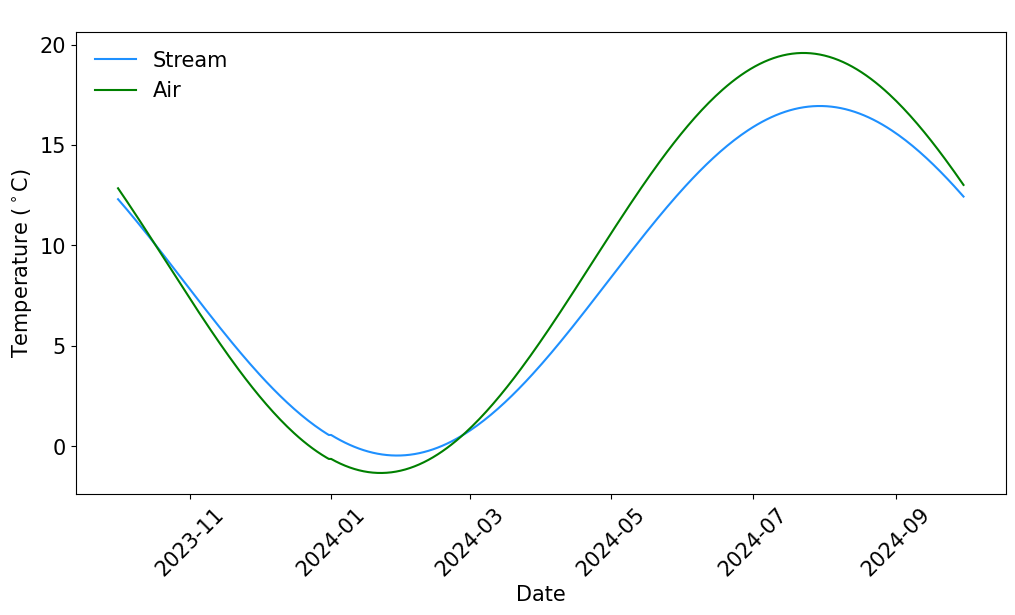

In [12]:
print(group_df.info())

fontsize =15
plt.figure(figsize=(12, 6))
plt.plot( group_df['Date'],  group_df['fit_stream'], label='Stream', color='dodgerblue')
plt.plot( group_df['Date'],  group_df['fit_air'], label='Air', color='green')


# Get the index of the minimum temperature for each curve to calculate amplitude
min_idx_air = np.argmin( group_df['fit_air'] )
min_idx_stream = np.argmin( group_df['fit_stream'] )

# Get the maximum temperature value for each curve
max_val_air = np.max( group_df['fit_air'] )
max_val_stream = np.max( group_df['fit_stream'] )

date_range = pd.date_range(start= group_df['Date'].iloc[0], end= group_df['Date'].iloc[-1], freq='D')
print(date_range)

# Add labels, title, and legend
plt.xticks(fontsize= fontsize , rotation = 45 )
plt.yticks(fontsize= fontsize)
plt.xlabel('Date' , fontsize= fontsize  )
plt.ylabel('Temperature ($^\circ$C)', fontsize= fontsize)
plt.title(' ')
plt.legend( fontsize= fontsize , frameon=False )
plt.grid( False)

# Show the plot
plt.show()

for summer

summer_months = [6,7,8]

summer_missing_data_threshold = 0.90 * (30+31+31)

In [13]:
amp_df_summer = pd.DataFrame({
                        "site": [ "00000000"],
      "water_year": [  0 ],
                        "amp": [ 0.0 ],
     "ph_l": [  0.0  ]
                                })

df_cleaned_summer = df_cleaned[ df_cleaned['Month'].isin(summer_months) ]

# Group by both site_no and water_year
grouped = df_cleaned_summer.groupby(['site_no', 'water_year'])
print(grouped)

for (site_no, water_year), group_df in grouped:


    num_rows = group_df.shape[0]
    print("Number of rows:", num_rows)
    if num_rows < summer_missing_data_threshold:
        print("stop")
    else:
        print(f"Processing site_no: {site_no}, water_year: {water_year}")
        print(f"DataFrame shape: {group_df.shape}")
        print(group_df)

        air_model =    smf.ols('tmean ~ sin_rday + cos_rday',      data=  group_df ).fit()
        #print("air_model:",air_model.summary())
        air_model_coefficients = air_model.params
        air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
        group_df['fit_air'] = air_model.predict( group_df )

        group_df['ST']=group_df['00010_Mean']
        stream_model = smf.ols('ST ~ sin_rday + cos_rday', data= group_df ).fit()
        #print("stream_model:",stream_model.summary())
        stream_model_coefficients = stream_model.params
        stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
        #print("stream_amp:", stream_amp)
        group_df['fit_stream'] = stream_model.predict( group_df )
        ## phase
        ph_stream=  ( units_day/(2*math.pi) ) *  ( (3 * math.pi / 2) - math.atan( stream_model_coefficients[2] / stream_model_coefficients[1] ) )
        ph_air =    ( units_day/(2*math.pi) ) * ( (3 * math.pi / 2) - math.atan(  air_model_coefficients[2] / air_model_coefficients[1] )      )
        #print("ph_stream:", ph_stream)
        #print("ph_air:", ph_air)
        ph_l = ph_stream - ph_air
        ##
        amp_df_summer0 = pd.DataFrame({
                                "site": [site_no]
           , "water_year": [  water_year ]
                                    ,"amp": [stream_amp / air_amp]
           , "ph_l": [ ph_l ]
                                })

        amp_df_summer=pd.concat( [ amp_df_summer,amp_df_summer0] )

amp_df_summer = amp_df_summer[1:]

Number of rows: 51
stop
Number of rows: 92
Processing site_no: 13340600, water_year: 2001
DataFrame shape: (92, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
2070  19.618000  13340600  2001-06-01  4.183052        11.8      5310.0   
2071  10.134001  13340600  2001-06-02  4.200266        12.1      5150.0   
2072   7.141000  13340600  2001-06-03  4.217481         9.5      4730.0   
2073   5.855000  13340600  2001-06-04  4.234695         7.4      5690.0   
2074   8.425000  13340600  2001-06-05  4.251909         7.1      4810.0   
...         ...       ...         ...       ...         ...         ...   
2157  21.613001  13340600  2001-08-27  5.680688        18.0       642.0   
2158  18.345001  13340600  2001-08-28  5.697902        18.4       629.0   
2159  20.190001  13340600  2001-08-29  5.715116        18.1       628.0   
2160  21.411001  13340600  2001-08-30  5.732331        18.2       625.0   
2161  19.711000  13340600  2001-08-31  5.749545        18.2

/tmp/ipython-input-1470340805.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 92
Processing site_no: 13340600, water_year: 2010
DataFrame shape: (92, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
5357  12.521001  13340600  2010-06-01  4.183052         8.5      7860.0   
5358  11.096001  13340600  2010-06-02  4.200266         8.5      8320.0   
5359  11.977000  13340600  2010-06-03  4.217481         8.0     13900.0   
5360  12.893001  13340600  2010-06-04  4.234695         8.0     13500.0   
5361  13.530001  13340600  2010-06-05  4.251909         8.0     14100.0   
...         ...       ...         ...       ...         ...         ...   
5444  12.959001  13340600  2010-08-27  5.680688        17.0       812.0   
5445  10.293000  13340600  2010-08-28  5.697902        15.5       811.0   
5446  11.395000  13340600  2010-08-29  5.715116        14.5       925.0   
5447  12.634001  13340600  2010-08-30  5.732331        14.0       966.0   
5448  12.474001  13340600  2010-08-31  5.749545        14.0       878.0   

      M

/tmp/ipython-input-1470340805.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

Number of rows: 92
Processing site_no: 13340600, water_year: 2019
DataFrame shape: (92, 11)
          tmean   site_no        Date     rad_d  00010_Mean  00060_Mean  \
8644  18.777399  13340600  2019-06-01  4.183052        10.0      9010.0   
8645  20.004000  13340600  2019-06-02  4.200266        10.4      9040.0   
8646  17.299900  13340600  2019-06-03  4.217481        10.8      8930.0   
8647  15.954900  13340600  2019-06-04  4.234695        10.8      8520.0   
8648  16.840399  13340600  2019-06-05  4.251909        10.5      7770.0   
...         ...       ...         ...       ...         ...         ...   
8731  17.314400  13340600  2019-08-27  5.680688        16.5       757.0   
8732  20.955500  13340600  2019-08-28  5.697902        16.9       741.0   
8733  16.939400  13340600  2019-08-29  5.715116        16.9       727.0   
8734  20.532499  13340600  2019-08-30  5.732331        17.4       738.0   
8735  22.514999  13340600  2019-08-31  5.749545        17.9       729.0   

      M

/tmp/ipython-input-1470340805.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  air_amp= (air_model_coefficients[2]**2 + air_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stream_amp=(stream_model_coefficients[2]**2 + stream_model_coefficients[1]**2)**0.5
/tmp/ipython-input-1470340805.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ph_stream=  ( units_day/(2*

In [14]:
amp_df_summer

,site,water_year,amp,ph_l
0,13340600,2001,1.210626,-1.323520
0,13340600,2002,0.879468,15.856223
0,13340600,2003,1.381784,6.266258
0,13340600,2004,1.172598,4.247777
0,13340600,2005,0.865423,4.728580
0,13340600,2006,1.197721,8.327448
0,13340600,2007,1.230534,4.299566
0,13340600,2008,0.533389,21.998794
0,13340600,2009,1.776476,3.734516
0,13340600,2010,0.908112,10.602203
